<a href="https://colab.research.google.com/github/nvarasp/FinalProject_IRWA/blob/main/search-engine/Search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Search Engine

In this notebook, we will first gather data from twitter related to the Covid-19 topic. Then, we will build a search engine by preprocessing the data, contructing an inverted index and a ranking methodology.

### 0 - Imports and Setup

In this section, we mount drive and install and import the required libraries.

In [1]:
%%time
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_FILENAME = "/content/drive/My Drive/IRWA/FinalProject/data/tweets_covid_collected.json"
INPUT_FILENAME= "/content/drive/My Drive/IRWA/FinalProject/data/tweets_covid.json"
save_json="/content/drive/My Drive/IRWA/FinalProject/data/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 1.08 ms, sys: 0 ns, total: 1.08 ms
Wall time: 1.3 ms


In [2]:
%%capture
!pip install config

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import operator

from collections import Counter
from config import *
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import nltk.stem as stemmers
from array import array
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import json
import datetime
import time
from wordcloud import WordCloud, ImageColorGenerator
import re
import string
import collections
from numpy import linalg as la
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer

from nltk.corpus import stopwords
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1 - Data Collection

In this section, we gather data from twitter. The output will be stored in the file specified in the first cell. This step is optional, and can be controlled through the flag SCRAP_DATA.

In [4]:
SCRAP_DATA =False #if True we will gather data from twitter, false will use the specified file

In [5]:
## access token informations 
access_token1 = "1222829162873966592-bZFEBawAf3miUZbbEH29HHRw7NjPPM"
access_token_secret1 = "ZIt6kCYMFkRWHgqaq3Y8wVhv7X9bwDEBzFc0l94lDcnDN"

consumer_key1 = "fH09Y3OVJmPcEUE3tJ2rxipfg"
consumer_secret1 = "5tiWpOA9QtMc9EV6Jr7k9gSG0aZHyVwV20H9PHFG0mHyPl9q8d"

In [6]:
auth = OAuthHandler(consumer_key1, consumer_secret1)
auth.set_access_token(access_token1, access_token_secret1)
api = API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
class MyStreamListener(StreamListener):
    """
    Twitter listener, collects streaming tweets and output to a file
    """
    def __init__(self, api, OUTPUT_FILENAME, stop_condition=10):
        """
        initialize the stream, with num. of tweets and saving the outputfile
        """
        
        # this line is needed to import the characteristics of the streaming API
        super(MyStreamListener, self).__init__()
        
        # to-count the number of tweets collected        
        self.num_tweets = 0
        
        # save filename
        self.filename = OUTPUT_FILENAME
        
        # stop-condition
        self.stop_condition = stop_condition
        

    def on_status(self, status):
        
        """
        this function runs each time a new bunch of tweets is retrived from the streaming
        """
        
        with open(self.filename, "a+") as f:
            tweet = status._json
            
            f.write(json.dumps(tweet) + '\n')
            #self.output.append(tweet)
            self.num_tweets += 1
        
            # Stop condition        
            if self.num_tweets <= self.stop_condition:
                return True
            else:
                return False
        

    def on_error(self, status):
        """
        function useful to handle errors. It's possible to personalize it 
        depending on the way we want to handle errors
        """
        
        print(status)
        #returning False in on_error disconnects the stream
        return False

In [8]:
%%time
if SCRAP_DATA:
  stop_condition = 1000

  l = MyStreamListener(api, OUTPUT_FILENAME, stop_condition)
  # here we recall the Stream Class from Tweepy to input the authentication info and our personalized listener 
  stream = Stream(auth=api.auth, listener=l)


  # keywords we decided to track 
  TRACKING_KEYWORDS = ["#coronavirus","#covid-19","#corona","#SARSCoV2","#WearAMask","#stayhome","#quarantine","#quarantinelife","#lockdown","#pcr","#CoronavirusOutbreak"]

  stream.filter(
      track=TRACKING_KEYWORDS, 
      async=False, 
      languages = ["en"]
  )

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


#### 1.1 **Report** Section 1: Data Collection

First, we will read the data from the file that contains the tweets.

In [9]:
with open(INPUT_FILENAME, "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

Then, we inspect our data.

In [10]:
df_tweets = pd.DataFrame.from_records(data)
#in case there are some duplicated tweets
df_tweets=df_tweets.drop_duplicates(subset=['id', 'id_str'])
df_tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_in_countries
0,Wed Nov 18 10:19:01 +0000 2020,1329006187384279042,1329006187384279042,"With the pressures of Brexit &amp; COVID-19, i...",False,"[0, 237]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1329006184850989058, 'id_str...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,None,NaN,None,None,"{'id': 867655190, 'id_str': '867655190', 'name...",None,None,None,None,False,0,0,False,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Nov 18 10:19:01 +0000 2020,1329006187535163392,1329006187535163392,RT @koshersemite: It’s coronavirus’s first bir...,False,"[0, 101]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1328912184689250305, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 285865405, 'id_str': '285865405', 'name...",None,None,None,None,False,29,0,False,False,False,en,{'created_at': 'Wed Nov 18 04:05:30 +0000 2020...,NaN,NaN,NaN,NaN,NaN
2,Wed Nov 18 10:19:01 +0000 2020,1329006187707199488,1329006187707199488,RT @Pollytics: Just a reminder that all of Aus...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 1014500145776349184, 'id_str': '1014500...",None,None,None,None,False,224,0,False,False,NaN,en,{'created_at': 'Wed Nov 18 06:23:43 +0000 2020...,NaN,NaN,NaN,NaN,NaN
3,Wed Nov 18 10:19:01 +0000 2020,1329006188248379392,1329006188248379392,RT @zerohedge: UK MP Suggests People Shouldn't...,False,"[0, 111]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1092357811604983809, 'id_str': '1092357...",None,None,None,None,False,94,0,False,False,False,en,{'created_at': 'Wed Nov 18 07:00:01 +0000 2020...,NaN,NaN,NaN,NaN,NaN
4,Wed Nov 18 10:19:01 +0000 2020,1329006188697169921,1329006188697169921,RT @RandPaul: Why does the left accept immune ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 385944134, 'id_str': '385944134', 'name...",None,None,None,None,False,2143,0,False,False,NaN,en,{'created_at': 'Tue Nov 17 19:56:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN


In [11]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51029 entries, 0 to 51068
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 51029 non-null  object 
 1   id                         51029 non-null  int64  
 2   id_str                     51029 non-null  object 
 3   full_text                  51029 non-null  object 
 4   truncated                  51029 non-null  bool   
 5   display_text_range         51029 non-null  object 
 6   entities                   51029 non-null  object 
 7   extended_entities          6772 non-null   object 
 8   source                     51029 non-null  object 
 9   in_reply_to_status_id      3870 non-null   float64
 10  in_reply_to_status_id_str  3870 non-null   object 
 11  in_reply_to_user_id        4241 non-null   float64
 12  in_reply_to_user_id_str    4241 non-null   object 
 13  in_reply_to_screen_name    4241 non-null   obj

Next, we retrieve some interesting statistics such as the number of retweets, unique tweets and unique users.

In [12]:
def print_retweets_uniqueTweets_uniqueUsers(df_tweets):
    #list of 0 if tweet is not reteeweted/1 for retweet or not
    retweets_ = df_tweets["retweeted_status"].apply(lambda x: 0 if str(x) == "nan" else 1)
    tot_retweets = sum(retweets_)
    unique_tweets = len(retweets_) - tot_retweets
    
    users_ = df_tweets.user.apply(lambda x: x["id"])
    
    tot_users = len(set(users_))
    
    print("The total number of retweets is: " + str(tot_retweets))
    print("The total number of unique tweets is: " + str(unique_tweets))
    print("The total number of unique users is: " + str(tot_users))
    print("The total number of tweets is: "+ str(len(retweets_)))


In [13]:
print_retweets_uniqueTweets_uniqueUsers(df_tweets)

The total number of retweets is: 31655
The total number of unique tweets is: 19374
The total number of unique users is: 41152
The total number of tweets is: 51029


Finally, we make a histogram of the most popular hasthags in the whole corpus.

In [14]:
def extract_hashtags():

    hashtags_lists = df_tweets["entities"].apply(lambda x: x["hashtags"])
    
    hashtags = hashtags_lists.apply(lambda x: x[0]["text"].lower() if x != [] else None)
    
    hashtags_by_frequency = Counter(hashtags)
    hashtags_by_frequency = {k: hashtags_by_frequency[k] for k in hashtags_by_frequency if k!= None}
    
    return hashtags_by_frequency

In [15]:
hashtags_by_frequency = extract_hashtags()

In [16]:
df_hashtags = pd.DataFrame(list(hashtags_by_frequency.items()))
df_hashtags.columns = ["hashtag", "count"]
df_hashtags.set_index("hashtag", inplace=True)
df_hashtags.sort_values("count", inplace=True, ascending=False)

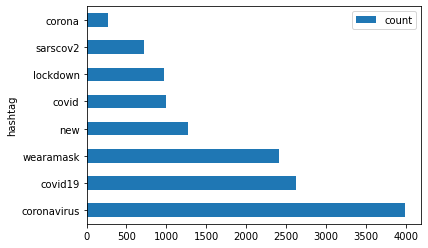

In [17]:
df_hashtags.head(8).plot.barh()
plt.show()

### 2 - Build the Search Engine

We collected both unique tweets and retweets, but to build the search engine we will only use only the original ones, since the retweets are reposts of other tweets. Therefore, we create a new dataframe with the original tweets.

In [18]:
original_tweets= df_tweets[(df_tweets['retweeted_status'].isnull())]
original_tweets = original_tweets.reset_index()


In [19]:
len(original_tweets)

19374

As seen before, we have 19.374 original tweets.

#### 2.1 Pre-processing the tweets

In [20]:
'''We take only the fields that will be shown in the query results, which are the tweet text, the username of the profile that published the tweet, 
the date of creation, the hashtags it contains, the number of likes and retweets and finally the url of the tweet.
So we create a new dataframe df_proc that only keeps those fields.
'''
df_proc = original_tweets[["full_text","created_at", "favorite_count","retweet_count"]]
df_proc["username"]=[user['screen_name'] for user in original_tweets.user]
df_proc["hashtags"]=[entities['hashtags'] for entities in original_tweets.entities]
df_proc["url"] = ["https://twitter.com/twitter/statuses/"+id for id in original_tweets.id_str]

df_proc.rename(columns={'full_text':'Tweet', 'username':'Username', 'created_at':'Date', 'hashtags':'Hashtags', 'favorite_count':'Likes', 'retweet_count':'Retweets', 'url':'Url'}, inplace = True)
df_proc = df_proc[['Tweet','Username' ,'Date','Hashtags','Likes','Retweets', 'Url']]
df_proc.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,Tweet,Username,Date,Hashtags,Likes,Retweets,Url
0,"With the pressures of Brexit &amp; COVID-19, i...",SpeedyFuels,Wed Nov 18 10:19:01 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/132900618...
1,How your business can get a Covid-19 specific ...,ChannelRadio2,Wed Nov 18 10:19:02 +0000 2020,"[{'text': 'BBunker', 'indices': [78, 86]}]",0,1,https://twitter.com/twitter/statuses/132900618...
2,@robjeffecology @CarolineLucas Hate to say thi...,melb4886,Wed Nov 18 10:19:02 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/132900619...
3,And counting https://t.co/Ma9pNQCfPu,Joshwawaaa,Wed Nov 18 10:19:02 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/132900619...
4,@Adam60670517 @kathycastro @jachristian It's n...,malangittler,Wed Nov 18 10:19:02 +0000 2020,[],1,0,https://twitter.com/twitter/statuses/132900619...


In [21]:
#list of stopwords in english
STOPWORDS = set(stopwords.words("english"))

In [22]:
def getTerms(line):
        
    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))
    
    line = line.replace("RT", "").strip()# remove "RT" string indicating a retweet
    line = line.replace("#", "").strip()# remove "#" string
    line=  line.lower() ## Transform in lowercase
    line= re.sub(r'[^\w\s]','',line).strip()    # removing all the punctuations
    line= line.encode('ascii', 'ignore').decode('ascii')#Remove emojis

    line=  line.split() ## Tokenize the text to get a list of terms
    line=[x for x in line if x not in stops]  ##eliminate the stopwords 
    #line=[stemming.stem(word) for word in line] 
    #We have decided to lemmatize instead of stemming since we have tried both methods and this one works better in this case.
    wnl = nltk.WordNetLemmatizer()
    line=[wnl.lemmatize(word) for word in line]
    
    return line

In [23]:
texts=[]
for line in df_proc['Tweet']:
  texts.append(getTerms(line))

df_proc['Tweet_proc']=texts

In [24]:
df_proc

,Tweet,Username,Date,Hashtags,Likes,Retweets,Url,Tweet_proc
0,"With the pressures of Brexit &amp; COVID-19, i...",SpeedyFuels,Wed Nov 18 10:19:01 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/132900618...,"[pressure, brexit, amp, covid19, never, import..."
1,How your business can get a Covid-19 specific ...,ChannelRadio2,Wed Nov 18 10:19:02 +0000 2020,"[{'text': 'BBunker', 'indices': [78, 86]}]",0,1,https://twitter.com/twitter/statuses/132900618...,"[business, get, covid19, specific, communicati..."
2,@robjeffecology @CarolineLucas Hate to say thi...,melb4886,Wed Nov 18 10:19:02 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/132900619...,"[robjeffecology, carolinelucas, hate, say, won..."
3,And counting https://t.co/Ma9pNQCfPu,Joshwawaaa,Wed Nov 18 10:19:02 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/132900619...,"[counting, httpstcoma9pnqcfpu]"
4,@Adam60670517 @kathycastro @jachristian It's n...,malangittler,Wed Nov 18 10:19:02 +0000 2020,[],1,0,https://twitter.com/twitter/statuses/132900619...,"[adam60670517, kathycastro, jachristian, binar..."
...,...,...,...,...,...,...,...,...
19369,California is now reporting more #coronavirus ...,LauraGarciaNBC,Thu Dec 17 13:30:00 +0000 2020,"[{'text': 'coronavirus', 'indices': [33, 45]}]",12,4,https://twitter.com/twitter/statuses/133956350...,"[california, reporting, coronavirus, case, cou..."
19370,Are you wearing your face mask properly?👇\n\n#...,masksrusuk,Thu Dec 17 13:30:00 +0000 2020,"[{'text': 'WearAMask', 'indices': [43, 53]}, {...",0,0,https://twitter.com/twitter/statuses/133956350...,"[wearing, face, mask, properly, wearamask, mas..."
19371,Commission closing in on deal for up to 200M d...,ZyiteGadgets,Thu Dec 17 13:30:03 +0000 2020,"[{'text': 'coronavirus', 'indices': [62, 74]}]",0,0,https://twitter.com/twitter/statuses/133956350...,"[commission, closing, deal, 200m, dos, novavax..."
19372,⚠️🦠 Grieving alone: Some Turks want lockdown t...,NewsbyMorB,Thu Dec 17 13:30:03 +0000 2020,"[{'text': 'virus', 'indices': [165, 171]}, {'t...",0,0,https://twitter.com/twitter/statuses/133956351...,"[grieving, alone, turk, want, lockdown, halt, ..."


In [25]:
#Extracting the dataframe in case it is needed in another file.
df_proc.to_csv(save_json+'df_proc.csv', index=False)

#### 2.2 Reports

To generate the wordcloud of the whole corpus, first we compute the bag of words

In [26]:
def get_bagofwords(data, attribute):
  bag_of_words = {}
  for tweet in data[attribute]:
    for text in tweet:
      # remove "RT" string indicating a retweet
      text = text.replace("RT", "").strip()
      text = text.replace("#", "").strip()
      # lowering text
      text = text.lower()
      
      # removing all the punctuations
      text = re.sub(r'[^\w\s]','',text).strip()
      text= text.encode('ascii', 'ignore').decode('ascii')
      
      # tokenize the text
      lst_text = text.split()
      
      # remove stopwords
      lst_text = [x for x in lst_text if x not in STOPWORDS]
          
      # create bag-of-words - for each word the frequency of the word in the corpus
      for w in lst_text:
          if w not in bag_of_words:
              bag_of_words[w] = 0
          bag_of_words[w]+=1
  return bag_of_words

In [27]:
bag_of_words=get_bagofwords(df_proc, "Tweet_proc")

In [28]:
#Function to plot the wordcloud
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

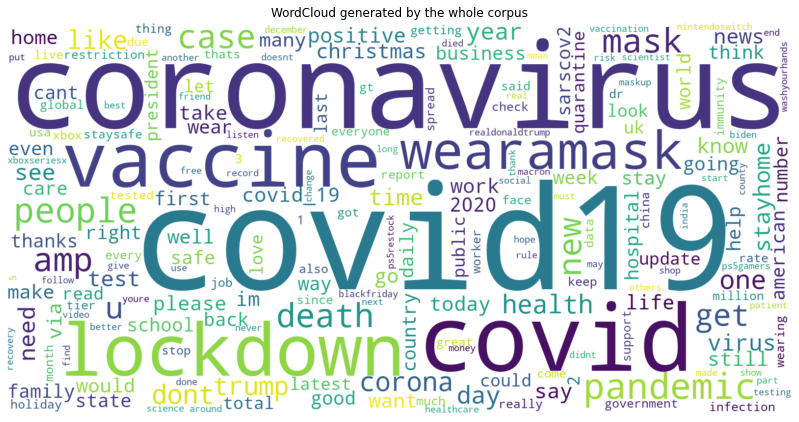

In [29]:
plot_wordcloud("WordCloud generated by the whole corpus", bag_of_words)



In [30]:
#Function to create a barplot
def plot_barplot(bag_of_words):
  frequent_words=sorted(bag_of_words.items(), key=operator.itemgetter(1), reverse=True)

  x, y = zip(*frequent_words[:10])
  plt.barh(x,y)
  plt.xlabel("Count")
  plt.ylabel("Words")
  plt.title("Bar plot of most frequent words")

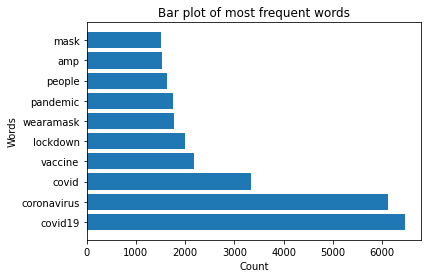

In [31]:
plot_barplot(bag_of_words)

#### 2.3 Construct Index

In [32]:
def create_tf_idf_index(data, col, numDocuments):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    data: dataframe with all the tweets
    col: the column where the tweet text is located
    numDocuments -- total number of tweets
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of tweets these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each tweet
    df - number of tweets each term appear in
    idf - inverse document frequency of each term
    """
       
    index=defaultdict(list)
    tf=defaultdict(list) #term frequencies of terms in tweets (tweets in the same order as in the main index)
    df=defaultdict(int)         #document frequencies of terms in the corpus
    idf=defaultdict(float)
    ## ===============================================================        
        ## create the index for the **currenttweet** and store it in termdict
        ## termdict ==> { ‘term1’: [currenttweet, [list of positions]], ...,‘termn’: [currenttweet, [list of positions]]}
        
        ## Example: if the currenttweet has id 1 and his text is "web retrieval information retrieval":
        ## termdict==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}
        ## the term ‘web’ appears in tweet 1 in positions 0, 
        ## the term ‘retrieval’ appears in tweet 1 in positions 1 and 4
        ## ===============================================================
    for i, row in data.iterrows():#iterate the dataframe
        row_id = i

        termdict={} #here we store a dictionary from the word to a list with the current tweet and the postings
        for position, term in enumerate(row[col]): 
          try:# if the term is already in the dict append the position to the corresponding list
            termdict[term][1].append(position)
          except:# Add the new term as dict key and initialize the array of positions and add the position
            termdict[term]=[row_id, ([position])] 
        
        # Compute the denominator to normalize term frequencies
        # norm is the same for all terms of a document.
        norm=0
        for term, postings in termdict.items():
            # postings is a list containing tweet_id and the list of positions for current term in current tweet: 
            # posting ==> [tweet_id, [list of positions]] 
            # you can use it to inferr the frequency of current term  
            norm+=len(postings[1])**2

        norm=math.sqrt(norm)
        

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdict.items():     
            # append the tf for current term (tf = term frequency in current tweet/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))  
            #increment the tweet frequency of current term (number of tweets containing the current term)
            df[term]+=1  # increment df for current term          
        
        #merge the current page index with the main index
        for term, posting in termdict.items():
          index[term].append(posting)
            
        # Compute idf 
    for term in df:
        idf[term] = np.round(np.log(float(numDocuments/df[term])),4)

    return index, tf, df, idf

In [33]:
start_time = time.time()
numDocuments = len(df_proc["Tweet_proc"])
index, tf, df, idf= create_tf_idf_index(df_proc,"Tweet_proc", numDocuments)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))


Total time to create the index: 7.66 seconds


#### 2.4 Ranking

##### 2.3.1 Ranking documents with tf-idf and cosine similarity

In [34]:
def rankDocuments(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted tweets frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked tweets
    """
        
    # We're interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # We call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate docVectors for matching tweets
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # term is in tweet 26 in positions 1,4, .....
            
            #tf[term][0] will contain the tf of the term "term" in the tweet 26            
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term] 

    # calculate the score of each tweet
    # compute the cosine similarity between queyVector and each docVector:
    
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    
    while len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        resultDocs = search_tf_idf(query, index)    

    return resultDocs

In [35]:
def search_tf_idf(query, index):
    '''
    output is the list of tweets that contain all of the query terms. 
    So, we will get the list of tweets for each query term, and take the AND of them.
    '''
    query=getTerms(query)
    docs= set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]

            if len(docs)==0:
              docs = set(termDocs)
            else:
              docs= docs & set(termDocs)
            
            # docs = docs Union termDocs
           
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf)   
    return ranked_docs

In [36]:
print("Insert your query:\n")
query = input()
ranked_docs = search_tf_idf(query, index)    
top  = 20

num_results=min(len(ranked_docs), top)
print("\n======================\nTop {} results out of {} for the seached query:\n".format(num_results, len(ranked_docs)))
n=1
for d_id in ranked_docs[:num_results]:
  print("{} tweet: {} \n".format(n, d_id))
  print("Text: {}.\n".format(df_proc.iloc[d_id][0]))
  print("Username: {}. Date: {}. URL: {}\n".format(df_proc.iloc[d_id][1], df_proc.iloc[d_id][2], df_proc.iloc[d_id][6]))
  print("Retweets: {}. Likes: {}. Hashtags: {}\n".format(df_proc.iloc[d_id][5], df_proc.iloc[d_id][4], df_proc.iloc[d_id][3]))
  print("\n")
  n+=1


Insert your query:

covid19

Top 20 results out of 5509 for the seached query:

1 tweet: 6445 

Text: How Will the Future Remember COVID-19? (The Atlantic) #CoronaVirsus #COVIDー19 #COVID19 #CoronaVirusOutbreak #CoronaVirusPandemic https://t.co/VFB2pHgSGW https://t.co/P8cm9myOiN.

Username: jamesvgingerich. Date: Mon Dec 07 16:04:42 +0000 2020. URL: https://twitter.com/twitter/statuses/1335978549069672448

Retweets: 0. Likes: 0. Hashtags: [{'text': 'CoronaVirsus', 'indices': [54, 67]}, {'text': 'COVIDー19', 'indices': [68, 77]}, {'text': 'COVID19', 'indices': [78, 86]}, {'text': 'CoronaVirusOutbreak', 'indices': [87, 107]}, {'text': 'CoronaVirusPandemic', 'indices': [108, 128]}]



2 tweet: 13248 

Text: Covid-19 https://t.co/oZ5CuGtecb.

Username: rogerablackwell. Date: Wed Dec 16 22:17:39 +0000 2020. URL: https://twitter.com/twitter/statuses/1339333899412008964

Retweets: 0. Likes: 0. Hashtags: []



3 tweet: 7781 

Text: I Hate Covid-19.

Username: deehaw90. Date: Wed Dec 16 22:11:58 

##### 2.3.2 Ranking documents with our score and cosine similarity

The score we have implemented aims to prioritize the popular tweets, so that tweets which have had a bigger impact on other users are shown before.

The score we created to rank the documents uses the tf and idf values, but also the number of likes and retweets. In particular, our score is defined as: **Tweet_score = tf * idf * 0.6 + num_likes * 0.15 + num_retweets * 0.25**



In [37]:
def search_ourRanking(query, index, idf, tf):
    '''
    The output is the list of tweets that contain the query terms. 
    So, we will get the list of tweets for each query term, and take the union of them.
    '''
    query=getTerms(query)

    docs= set()
    for term in query:
        try:
            # store in termDocs the ids of the tweets that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]

            if len(docs)==0:
              docs = set(termDocs)
            else:
              docs= docs & set(termDocs)
            
           
        except:
            #term is not in index
            pass

    docs=list(docs)
    ranked_docs = ourRankDocuments(query, docs, index, idf, tf)   
    
    return ranked_docs

In [38]:
def ourRankDocuments(terms, docs, index, idf, tf):
  
  """
    Perform the ranking of the results of a search based on the tf-idf weights and popularity of the tweet (number of likes and retweets)
    
    Argument:
    terms -- list of query terms
    docs -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted tweets frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked tweets
    """  

  """It is the a very similar code to the one of the tf idf ranking function"""
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
  docVectors=defaultdict(lambda: [0]*len(terms)) 
    # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
  queryVector=[0]*len(terms)    
  query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # compute the norm for the query tf
  query_norm = la.norm(list(query_terms_count.values()))
    
  for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
      if term not in index:
          continue
                    
      ## Compute tf*idf(normalize tf as done with documents)
      queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 
       
        # Generate docVectors for matching docs
      for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....  # term is in doc 33 in positions 26,33, .....
            #tf[term][0] will contain the tf of the term "term" in the doc 26           

          if doc in docs: #if the docment is in the intersection
            #The first approach we did was with docVectors[doc][termIndex]=tf[term][docIndex] * popularity[term], where popularity was created in the index function
            '''The main change is here, since instead of giving the score to a tweet based only on the tf-idf score, we 
            also take into account the number of likes and retweets it has, taking into account the popularity of the tweets.'''
            docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]*0.6 + df_proc.iloc[doc]["Likes"]*0.15 + df_proc.iloc[doc]["Retweets"]*0.25
    
    # calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector:
  docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]        
  docScores.sort(reverse=True)

  resultDocs=[x[1] for x in docScores]
    
  while len(resultDocs) == 0:
      print("No results found, try again")
      query = input()
      resultDocs = search_ourRanking(query, index, idf, tf)   
    #print ('\n'.join(resultDocs), '\n')
  return resultDocs

In [39]:
print("Insert your query:\n")
query = input()
our_ranked_docs =  search_ourRanking(query, index, idf, tf)    
top  = 20

num_results=min(len(our_ranked_docs), top)
print("\n======================\nTop {} results out of {} for the seached query:\n".format(num_results, len(our_ranked_docs)))
n=1
for d_id in our_ranked_docs[:num_results]:
  print("{} tweet: {} \n".format(n, d_id))
  print("Text: {}.\n".format(df_proc.iloc[d_id][0]))
  print("Username: {}. Date: {}. URL: {}\n".format(df_proc.iloc[d_id][1], df_proc.iloc[d_id][2], df_proc.iloc[d_id][6]))
  print("Retweets: {}. Likes: {}. Hashtags: {}\n".format(df_proc.iloc[d_id][5], df_proc.iloc[d_id][4], df_proc.iloc[d_id][3]))
  print("\n")
  n+=1


Insert your query:

covid19

Top 20 results out of 5509 for the seached query:

1 tweet: 3396 

Text: #new LLC co-owned by Ilhan Omar's husband got $635K in #COVID-19 relief https://t.co/4wMlVE3F8m via @nypost.

Username: kevincorke. Date: Mon Dec 07 14:20:49 +0000 2020. URL: https://twitter.com/twitter/statuses/1335952406505525250

Retweets: 3413. Likes: 4530. Hashtags: [{'text': 'new', 'indices': [0, 4]}, {'text': 'COVID', 'indices': [55, 61]}]



2 tweet: 4624 

Text: Canadians warned to shelter at home unless your job makes money for someone richer

#COVID19 #cdnpoli #coronavirus https://t.co/M7aNtux8bn.

Username: TheBeaverton. Date: Mon Dec 07 15:02:30 +0000 2020. URL: https://twitter.com/twitter/statuses/1335962898053681152

Retweets: 522. Likes: 1506. Hashtags: [{'text': 'COVID19', 'indices': [84, 92]}, {'text': 'cdnpoli', 'indices': [93, 101]}, {'text': 'coronavirus', 'indices': [102, 114]}]



3 tweet: 8718 

Text: The National Cathedral in D.C. rang its bell 300 times for th